In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, JLD2, OrdinaryDiffEq
using Plots;

In [3]:
JLD2.@load("Ocean_geostrophic_velocity.jld2");
UV = interpolateVF(Lon, Lat, Time, UT, VT);

In [4]:
# Parameters
grid_resolution        = 200
quadrature_order       = 5
nevs                   = 20
ϵ                      = 10
num_steps              = 9
t_initial              = minimum(Time)
solver_tolerance       = 1e-8
solver                 = OrdinaryDiffEq.BS5();

In [5]:
T(x, param) = flow(interp_rhs, x, [t_initial, t_initial + param], p=UV,
        tolerance=solver_tolerance,solver=solver)[end]

T (generic function with 1 method)

In [6]:
LL, UR = (-4.0, -34.0), (6.0, -28.0)
lon_resolution = grid_resolution
lat_resolution = Integer(floor((UR[2] - LL[2])/(UR[1] - LL[1])*grid_resolution))
ctx, _ = regularTriangularGrid((lon_resolution, lat_resolution), 
        LL, UR, quadrature_order = quadrature_order);
bdata = getHomDBCS(ctx, "all");

In [7]:
M = assembleMassMatrix(ctx, bdata=bdata);

In [9]:
evs = zeros(num_steps,nevs)

In [10]:
for i in 1:num_steps
    DTϵ(x) = linearized_flow_autodiff(y -> T(y,i*ϵ) , x)
    Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
    @time Kϵ = assembleStiffnessMatrix(ctx, Aϵ, bdata=bdata)
    evs[i,:], _ = eigs(Kϵ, M, nev=nevs, which=:SM)
    print(Int(i), "/" ,num_steps, "\n")
end
nothing

 18.007094 seconds (22.69 M allocations: 1.140 GiB, 1.34% gc time)
 18.046313 seconds (22.68 M allocations: 1.139 GiB, 3.26% gc time)
1/100
 15.212212 seconds (11.25 M allocations: 672.583 MiB, 0.47% gc time)
 14.982405 seconds (11.25 M allocations: 672.583 MiB, 0.52% gc time)
2/100
 15.179481 seconds (11.25 M allocations: 672.583 MiB, 0.48% gc time)
 14.699981 seconds (11.25 M allocations: 672.583 MiB, 0.44% gc time)
3/100
 15.311476 seconds (11.25 M allocations: 672.583 MiB, 0.44% gc time)
 14.694831 seconds (11.25 M allocations: 672.583 MiB, 0.52% gc time)
4/100
 15.129538 seconds (11.25 M allocations: 672.583 MiB, 0.45% gc time)
 14.767601 seconds (11.25 M allocations: 672.583 MiB, 0.46% gc time)
5/100
 15.215683 seconds (11.25 M allocations: 672.583 MiB, 0.44% gc time)
 14.620541 seconds (11.25 M allocations: 672.583 MiB, 0.48% gc time)
6/100
 15.365519 seconds (11.25 M allocations: 672.583 MiB, 0.47% gc time)
 14.614924 seconds (11.25 M allocations: 672.583 MiB, 0.49% gc time)
7/

57/100
 18.115956 seconds (11.25 M allocations: 672.583 MiB, 0.30% gc time)
 11.615934 seconds (11.25 M allocations: 672.583 MiB, 0.63% gc time)
58/100
 18.339305 seconds (11.25 M allocations: 672.583 MiB, 0.38% gc time)
 11.533477 seconds (11.25 M allocations: 672.583 MiB, 0.50% gc time)
59/100
 18.254041 seconds (11.25 M allocations: 672.583 MiB, 0.37% gc time)
 11.394199 seconds (11.25 M allocations: 672.583 MiB, 0.50% gc time)
60/100
 18.301757 seconds (11.25 M allocations: 672.583 MiB, 0.31% gc time)
 11.366864 seconds (11.25 M allocations: 672.583 MiB, 0.63% gc time)
61/100
 18.375132 seconds (11.25 M allocations: 672.583 MiB, 0.37% gc time)
 11.318907 seconds (11.25 M allocations: 672.583 MiB, 0.64% gc time)
62/100
 18.505189 seconds (11.25 M allocations: 672.583 MiB, 0.30% gc time)
 11.242367 seconds (11.25 M allocations: 672.583 MiB, 0.65% gc time)
63/100
 18.573644 seconds (11.25 M allocations: 672.583 MiB, 0.39% gc time)
 11.152944 seconds (11.25 M allocations: 672.583 MiB, 

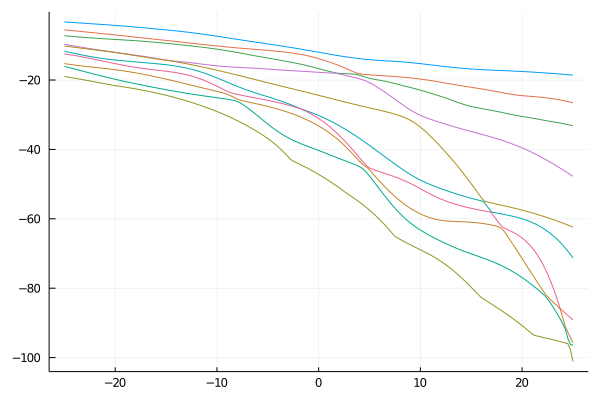

In [11]:
Plots.plot(ϵ:ϵ:num_steps*ϵ, evs, legend=false, fmt = :png)

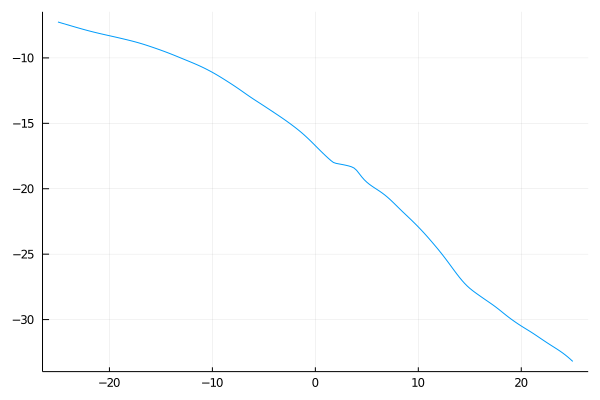

In [15]:
Plots.plot(ϵ:ϵ:num_steps*ϵ, evs[1:4], legend=false, fmt = :png)

In [18]:
using DelimitedFiles

In [19]:
writedlm("D:/ocean_stop_complete"*Int(num_steps)*".csv", [ϵ:ϵ:num_steps*ϵ  evs], ",")